# 주의사항

1. 코랩 환경에서 진행되었기 때문에 코랩이 아니라면 실행이 불가할 수 있습니다.
2. 조금 더 자세한 설명은 구글 문서로 요약해놓았습니다.
   https://docs.google.com/document/d/1mpOUh3rG-pQ3uOUP9lIGHcF10pA13GlYnqW3_OBv4TE/edit?usp=sharing

# 필요한 패키지 설치 및 import

In [1]:
!pip install torchtext==0.10.01 #버전이 이와 동일해야 에러가 나지 않음

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 28.6 MB/s 
     |████████████████████████████████| 831.4 MB 6.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.1 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

# 재현을 위해 랜덤 시드를 설정

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 데이터 로딩

In [4]:
!python3 -m spacy download de_core_news_sm
!python3 -m spacy download en_core_web_sm
import en_core_web_sm, de_core_news_sm
spacy_en = en_core_web_sm.load()
spacy_de = de_core_news_sm.load()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 28.3 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 33.8 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Tokenizer 정의

In [5]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

# 입력되는 벡터 생성
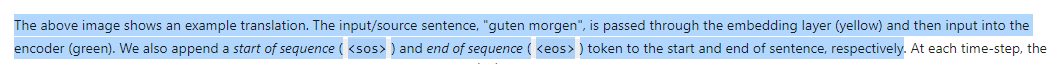

프로젝트 1에 명시된 바와 같이 각 입력 문장을 토크나이징을 진행해 나온 벡터의 첫부분에 sos, 끝부분에 eos를 넣어 입력형식을 맞춥니다.

In [6]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

# Data split

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 981kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 278kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 270kB/s]


# Vovabulary

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

# GPU 사용을 위해 필요한 코드

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# iterator 설정


In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

# 인코더
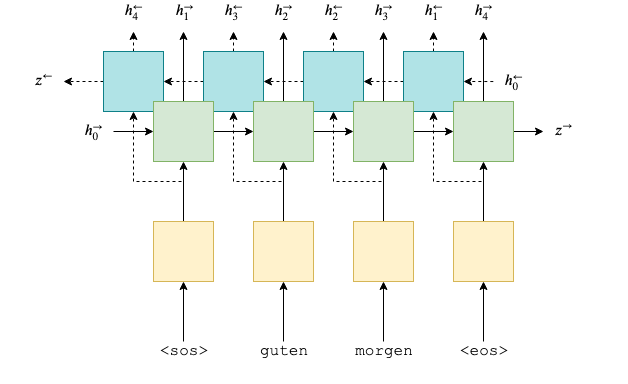

INPUT

'gutten morgen'이 [ sos, 'gutten', 'morgan', eos ]로 전처리되어 입력되고, sos는 start of sequence, eos는 end of sequence를 의미합니다. 이 벡터는 처음에 embedding층에 들어가게 되면 embedding vector로 변환되고, 이는 GRU층에 전달되게 됩니다.


GRU층은 forward와 backward 벡터를 둘 다 만들어 내는데, forward는 일반적인 context vector를 리턴하고 backward는 context vector의 반대방향의 벡터를 리턴합니다.
좀 더 자세히 설명하자면, [ sos, guten, morgan, eos] 가 있다고 가정할때
1. $\overrightarrow{x_0}$ = sos
2. $\overleftarrow{x_1}$ = guten
3. $\overleftarrow{x_0}$ = eos
4. $\overleftarrow{x_1}$ = morgen

이 되고, 여기서 각 $h_t$를 아래와 같이 계산합니다. 여기서 e는 임베딩하는 함수입니다. 이 부분은 아래 주석에서 체크포인트 (1)에 해당하는 부분입니다. 코드에서는 outputs라는 변수에 이 결과를 받았는데, 이것은 앞으로도 많이 사용될 $H$로, 각 hidden state를 열백터로 배치한 행렬입니다.

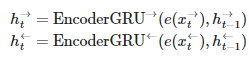


밑의 코드상의 체크포인트 (2) 번이 아래 사진과 같은 작업을 수행합니다. 

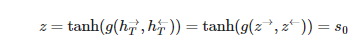

여기서 말하는 g는 linear layer를 뜻하는 것이고, h는 앞서 말한 hidden state, h의 방향은 어느쪽으로 가는 벡터인지를 명시해준 것입니다. 인코더와는 달리 디코더는 양방향이 아니기 때문에 $s_0$으로 전달해줄 단일 context vector가 필요한데, 이는 forward와 backward를 합치는 과정이 필요한데, 이를 코드에서는 두 벡터를 모두 linear layer에 넣으며 구현했습니다. 이에 대한 결과가 함수에서 반환하는 hidden에 대응됩니다.


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded) #...............................(1)


        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))) #.......(2)
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

# Attention

입력의 형식은 encoder와 동일하고, 출력은 attention vector입니다.

현재 t번째라고 할 때 Encoder에서 구한 forward와 backward 벡터를 모두 쌓아둔 $H$와와 decoder의 이전 hidden state인 $s_{t-1}$을 이용해 attention을 수행합니다.
여기서 attention vector를 $a_t$라고 정의하고, 벡터의 각 요소는 0~1 사이의 값을 가지며, 벡터 요소의 총 합은 1입니다.

우선, 이전 decoder hidden state와 encoder hidden state 사이의 energy를 계산합니다. t번째 에너지를 $E_t$라고 표현하고 그에 대한 식은 아래와 같습니다.

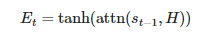

여기서의 attn은 linear layer입니다. 즉, 식은 linear layer를 거친 값에 tanh를 씌워주므로 activate function은 tanh함수입니다. 이에 대한 계산이 이루어지는 곳이 주석으로 표시된 체크포인트 (1)입니다.

지금 가지고 있는 $E_t$가 이루는 행렬 E는 dec hid dim X src len tensor입니다. 여기서, 이것을 단순히 1 X srclen으로 표현하고자, 아래와 같은 과정을 거쳐 최종적으로 도출할 벡터의 원소를 만들기 위한 $\hat a$를 계산합니다.

image.png

여기서 $v$는 1 X dec hid dim 행렬이므로, dec hid dim X src len tensor인 $E_t$와 행렬곱을 하면  1 X src len 행렬로 변환이 가능합니다. 여기서 형태상 $v$를 가중치라고 볼 수 있는데,이는 우리가 source sentence에서 각 토큰에 얼마나 집중해야 하는지를 나타낼 수 있습니다. 처음에는 random으로 시작되지만, 역전파 알고리즘이 진행되며 update됩니다. 이 부분이 구현된 곳이 주석에 표시된 체크포인트 (2)이고 공식 문서에 따르면 이를 linear layer로 구현했기에, 코드에서는 행렬 식으로 계산한 것이 아니라 energy를 linear layer에 넣어 계산했습니다.

마지막으로, attention vector는 $\hat a_t$에 softmax를 취해 얻어진 $a_t$ 입니다. 주석에 있는 체크포인트 (3)이 이에 해당하며, 식은 아래와 같습니다.

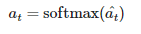



In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) #....(1)
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2) #.........(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1) #------------(3)

# Decoder
디코더의 입력은 attention, 인코더와 동일합니다.

우선 디코더 연산에는 이전 hidden state인 $s_{t-1}$, 인코더의 모든 hidden state를 담은 $H$, attention vector $a_t$가 필요합니다. 디코더에서는 가중치 벡터 $w_t$를 계산하기 위해 아래와 같은 식을 계산합니다. 이 식은 코드 주석상에 있는 체크포인트 (1)에 해당합니다.

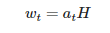

t번째 히든스테이트 $s_t$를 계산하기 위해, 이전 히든스테이트 $s_{t-1}$과 입력된 벡터의 t번째 요소($y_t$)를 임베딩한 $d(y_t)$를 활용하며 이에 대한 식은 아래와 같고 이는 코드 주석에 표시된 체크포인트 (2)와 같습니다.


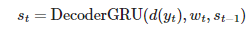

이제, t번째에서 구한 $d(y_t), w_t, s_t$를 linear layer인 $f$에 넣어 다음 단어(t+1번째 단어)를 예측합니다. t+1번째 단어는 $\hat{y}_{t+1}$로 표현되며, 식은 아래와 같고, 이는 코드 주석에 표시된 체크포인트 (3)에 해당합니다.

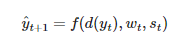

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs) #.........(1)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0)) #.........(2)
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))#.......(3)
        
        #prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0)


# Sequence to Sequence 모델
앞서 설명한 것을 모두 받아, 각 네트워크를 역할에 맞게 연결해 모델을 완성하는 코드입니다.


In [14]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

# 파라미터 설정 및 인코더와 디코더 등 모델 선언

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

# 가중치 초기화

In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

# train의 모수 count

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


# Train

In [18]:
optimizer = optim.Adam(model.parameters())

In [19]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [20]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# 학습 시작

재현됨과 더불어 loss가 올려진 코드보다 작음음



In [24]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 22s
	Train Loss: 4.128 | Train PPL:  62.053
	 Val. Loss: 4.591 |  Val. PPL:  98.572
Epoch: 02 | Time: 1m 26s
	Train Loss: 3.470 | Train PPL:  32.123
	 Val. Loss: 3.742 |  Val. PPL:  42.191
Epoch: 03 | Time: 1m 27s
	Train Loss: 2.912 | Train PPL:  18.397
	 Val. Loss: 3.412 |  Val. PPL:  30.321
Epoch: 04 | Time: 1m 26s
	Train Loss: 2.523 | Train PPL:  12.470
	 Val. Loss: 3.303 |  Val. PPL:  27.187
Epoch: 05 | Time: 1m 26s
	Train Loss: 2.234 | Train PPL:   9.336
	 Val. Loss: 3.235 |  Val. PPL:  25.411
Epoch: 06 | Time: 1m 25s
	Train Loss: 1.992 | Train PPL:   7.328
	 Val. Loss: 3.134 |  Val. PPL:  22.965
Epoch: 07 | Time: 1m 25s
	Train Loss: 1.772 | Train PPL:   5.884
	 Val. Loss: 3.182 |  Val. PPL:  24.085
Epoch: 08 | Time: 1m 26s
	Train Loss: 1.601 | Train PPL:   4.960
	 Val. Loss: 3.204 |  Val. PPL:  24.639
Epoch: 09 | Time: 1m 25s
	Train Loss: 1.492 | Train PPL:   4.446
	 Val. Loss: 3.315 |  Val. PPL:  27.512
Epoch: 10 | Time: 1m 26s
	Train Loss: 1.359 | Train PPL

# 성능 평가

In [25]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.159 | Test PPL:  23.554 |
